<span style="font-size: 5em">🦜</span>

# __LangGraph Essentials__
## Lab 5: Interrupt! Human In The Loop
<div style="display:flex; align-items:flex-start;">
  <img src="../assets/HITL.png" width="500" style="margin-right:15px;"/>
</div>

LangGraph's `interrupt()` function pauses graph execution and waits for human input before continuing. This enables human-in-the-loop workflows where an admin can review unexpected situations and decide how to proceed. Interrupts require a checkpointer to save state between pauses.


In [27]:
from IPython.display import Image, display
import operator
from typing import Annotated, List, Literal, TypedDict
from langgraph.graph import END, START, StateGraph
from langgraph.types import Command, interrupt

In [43]:
from langgraph.checkpoint.memory import InMemorySaver

memory = InMemorySaver()
config = {"configurable": {"thread_id": "3"}}

<a id='l5_memory'></a>


In [29]:
class State(TypedDict):
    nlist : Annotated[list[str], operator.add]  

<a id='l5_state'></a>


In [44]:
def node_a(state: State) -> Command[Literal["b", "c", END]]:
    print("Entered 'a' node")
    select = state["nlist"][-1]
    if select == "b":
        next_node = "b"
    elif select == "c":
        next_node = "c"
    elif select == "q":
        next_node = END
    else:
        admin = interrupt(f"Unexpected input '{select}'")
        print(admin)
        if admin == "continue":
            next_node = "b"
        else:
            next_node = END
            select = "q"
            
    return Command(
        update = State(nlist = [select]),
        goto = next_node
    )


def node_b (state: State) -> State:
    return(State(nlist = ["B"]))

def node_c (state: State) -> State:
    return(State(nlist = ["C"]))

In [ ]:
def node_a(state: State) -> Command[Literal["b", "c", END]]:
    print("Entered 'a' node")
    select = state["nlist"][-1]
    if select == "b":
        next_node = "b"
    elif select == "c":
        next_node = "c"
    elif select == "q":
        next_node = END
    else:
        admin = interrupt(f"Unexpected input '{select}'")
        #print(admin)
        if admin == "continue":
            next_node = "b"
        else:
            next_node = END
            select = "q"
            
    return Command(
        update = State(nlist = [select]),
        goto = next_node
    )


def node_b (state: State) -> State:
    admin = interrupt(f"You need to guess the next worb:")
    #print(admin)
    if admin == "b":
        return(State(nlist = ["B"]))
    else:
        return(State(nlist = ["WBONG"]))

def node_c (state: State) -> State:
    return(State(nlist = ["C"]))

<a id='interrupt_node'></a>


In [45]:
builder = StateGraph(State)

# Add nodes
builder.add_node("a", node_a)
builder.add_node("b", node_b)
builder.add_node("c", node_c)

# Add edges
builder.add_edge(START,"a")
builder.add_edge("b", END)
builder.add_edge("c", END)

# Compile
graph = builder.compile(checkpointer=memory)

<a id='l5_graph'></a>


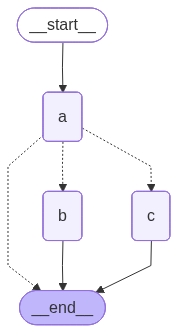

In [49]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [48]:
while True:
    user = input('b, c, or q to quit: ')
    input_state = State(nlist = [user])
    result = graph.invoke(input_state, config)

    if '__interrupt__' in result:
        print(f"Interrupt:{result}")
        msg = result['__interrupt__'][-1].value
        #print(msg)
        human = input(f"\nThe error was: {msg}\nTry another letter is easy like (1, 2, 3) but the first is going to be the last: ")

        human_response = Command(
            resume = human
        )
        result = graph.invoke(human_response, config)
        
    if result['nlist'][-1] == "q":
        print("quit")
        break


b, c, or q to quit:  c


Entered 'a' node


b, c, or q to quit:  s


Entered 'a' node
Interrupt:{'nlist': ['c', 'c', 'C', 's', 'q', 'c', 'c', 'C', 's', 's', 'B', 'b', 'b', 'B', 's', 'q', 'c', 'c', 'C', 's'], '__interrupt__': [Interrupt(value="Unexpected input 's'", id='97e4aa050fa912e3ef4959fddb1fdbb2')]}



The error was: Unexpected input 's'
Try another letter is easy like (1, 2, 3) but the first is going to be the last:  q


Entered 'a' node
q
quit


<a id='l5_execution'></a>


## Takeaways

Setup:

- [Node_a uses `interrupt()`](#interrupt_node) to pause execution when unexpected input occurs
- [Checkpointer enables interrupts](#l5_memory) by saving state between pause and resume

Execution:

- When interrupt is called, the [graph pauses](#l5_execution) and waits for human input
- The admin response determines whether to continue execution or end
- Graph state is preserved during the pause and restored when resuming

Try Next:

- Modify the interrupt logic to ask different questions based on the unexpected input
- Add interrupt calls in node_b or node_c to pause at different points in the workflow
